# Introduction to PC-VAE library

In [1]:
import sys
sys.path.append('/Users/personal/PycharmProjects/PC-VAE')
from pcvae.experiments import *
from pcvae.datasets import *
from pcvae.models import *
from pcvae.visualizations import *
from pcvae.util import list_options, list_models, list_datasets

## Checking available models, datasets and options

We can check the models and datasets available in `pcvae.models` and `pcvae.datasets`, using the `list_models` and `list_datsets` functions from `pcvae.util`:

In [2]:
list_models()
list_datasets()

Available models:
	PC
	Autoencoder
	M1
	ConsistantPC
	ConsistantPCLabeledOnly
	ConsistantPCLabeledOnlyPred
	ConsistantPCNoGenGrad
	ConsistantPCPredictor
	ConsistantPCSecondaryOnly
	M2
	PCM2
	ADGM
	SDGM
	DNN
	VAT


Available datasets:
	fashion_mnist
	kingma_mnist
	cifar
	svhn
	shar
	caltech_birds




We can see the options available for a given model and dataset using `pcvae.util.list_options`:

In [4]:
list_options(dataset=fashion_mnist, model=PC)

PC-VAE: A package for Prediction-Constrained and Semi-Supervised VAE learning

Dataset: Fashion_MNIST
Available options (defaults shown as ...[default]):

	


Model: pc
Available options (defaults shown as ...[default]):

	layers:               [[]]
	prediction_layers:    [[]]
	input_layer:         
	prediction_layer:    
	sampling_layer:      
	input_shape:         
	classes:              [2]
	latent_dim:           [2]
	sampled_predictor:    [False]
	sampled_encoder:      [False]
	regress_dims:         [-1]


Optimization with SGD
Available options (defaults shown as ...[default]):

	data:                
	valid_data:          
	augment:              [False]
	gen_args:            
	balance:              [True]
	fair:                 [True]
	lr:                   [0.001]
	optimizer:           
	epochs:               [10]
	plot_by_step:         [False]
	reduce_lr:            [True]
	seed:                 [543]
	labeled_frac:         [1]
	num_labeled:          [-1]
	batch_size:          

## Running an experiment

Running an experiment is as simple as calling the `run_trial` function from `pcvae.experiments`. This function takes a dataset class, a model class and any of the corresponding options as listed by `list_options`:

In [ ]:
results = run_trial(dataset=fashion_mnist, model=PC, 
          num_labeled=100, epochs=5,
          seed=984, balance=True, batch_size=200)

The trial results a dictionary with info about the run:

In [4]:
tuple(results.keys())

('model',
 'train_data',
 'valid_data',
 'test_data',
 'results',
 'labels',
 'args',
 'objective',
 'hp_trace')

## Visualization

We can use the result object to make various plots with functions from `pcvae.visualizations`. For example: we can use the `plot_history` function to plot a trace of the training loss or accuracy over the training epochs:

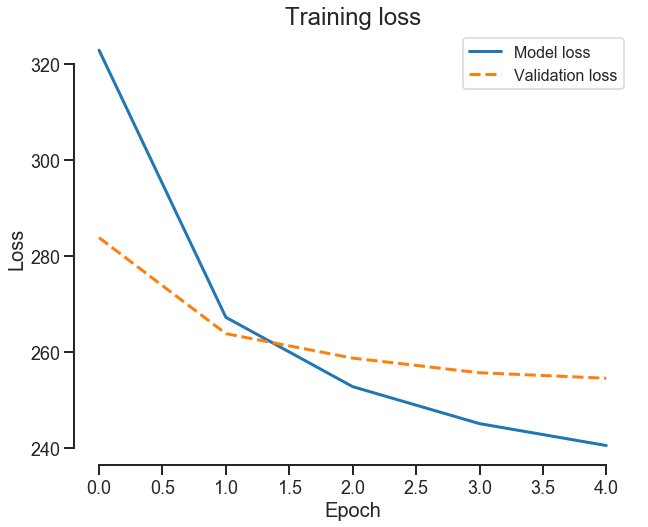

In [12]:
plot_history(results)
# Alt.: plot_history(results, metric='acc')

Use `plot_confusion` to display a confusion matrix:

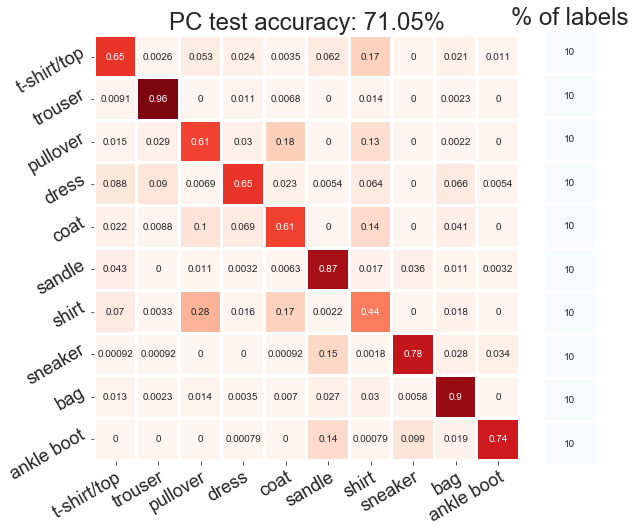

In [13]:
plot_confusion(results, split='test')

Use `plot_encodings` to display the test observations projected into the latent space. If the latent space is more than 2 dimensions, it will plot the first 2 principal components:

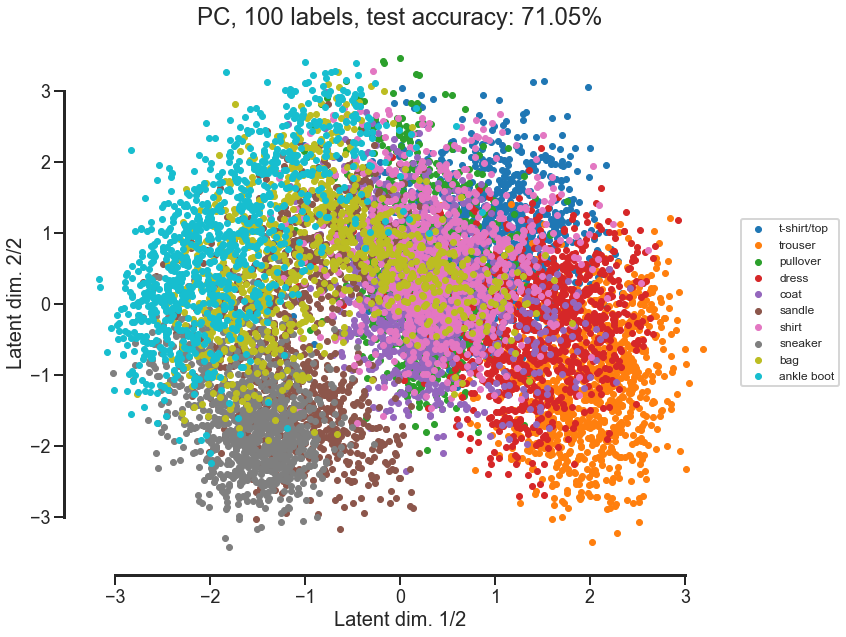

In [14]:
plot_encodings(results, split='test')

Use `plot_reconstructions` to display the test observations reconstructed through the model:

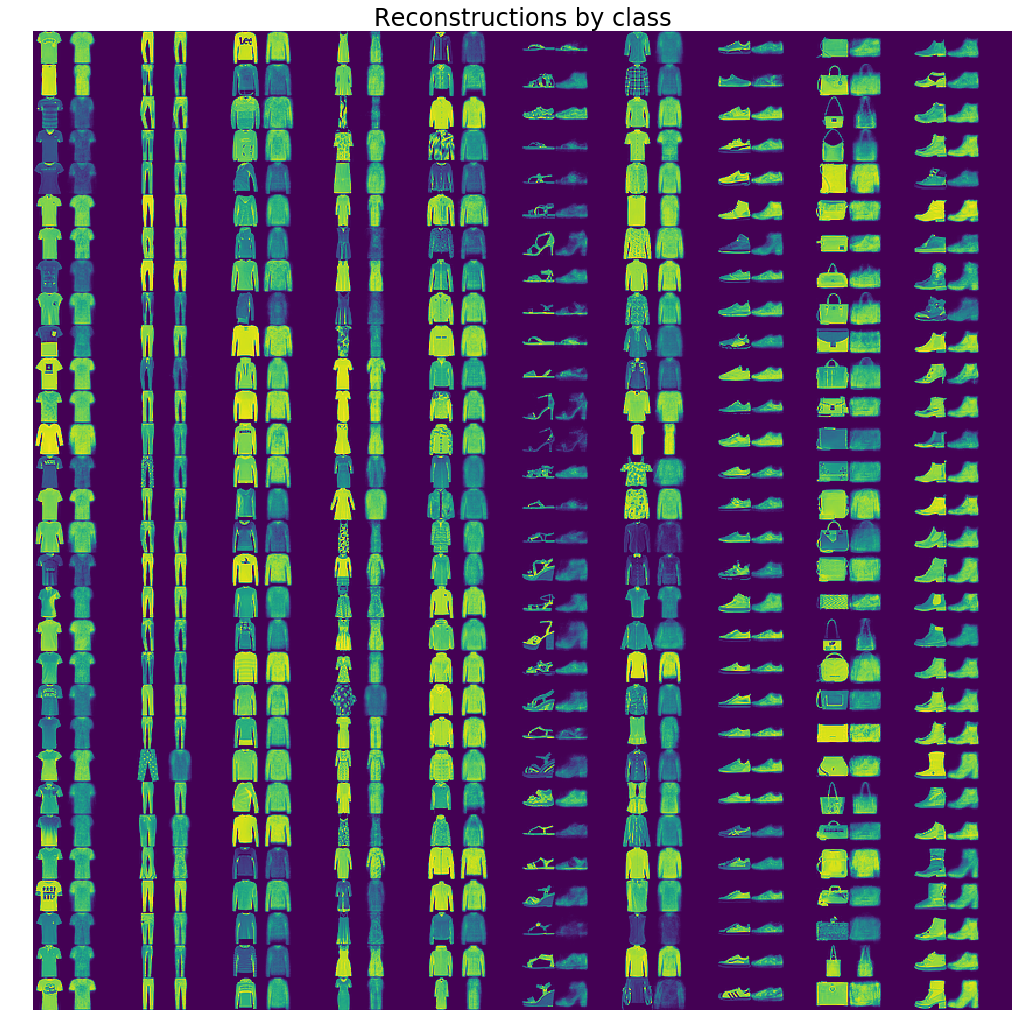

In [15]:
plot_reconstructions(results, split='test')

## Optimizing hyperparameters

We can use the `opt_hyperparameters` function to optimize the hyperparameters for the model. It has the same interface as `run_trial`, but allows us to pass a search space for any number of hyperparameters. It will then run up to `n_trials` runs, using Bayesian optimization to select trial parameters:

In [ ]:
results = opt_hyperparameters(dataset=kingma_mnist, model=PC,
          n_trials=10, num_labeled=100, epochs=10,
          
          LAMBDA     = uniform(1, 100),             # Uniform search space in specified range
          lr         = loguniform(1e-4, 1e-2),      # Logarithmic search space in specified range
          batch_size = integer(50, 200, step=50),   # Uniform search space with quantization
          balance    = categorical([True, False])   # Categorical search space
                              
          )

The results object will also carry information about all runs:

In [8]:
results['results']['table']

,num_labeled,epochs,LAMBDA,lr,batch_size,balance,model,train_acc,valid_acc,test_acc
0,100,10,44.630241,0.007120,50,False,pc,0.067688,0.066921,0.067649
0,100,10,18.009047,0.000715,150,False,pc,0.056873,0.056012,0.056516
0,100,10,48.720489,0.000752,50,True,pc,0.016901,0.017144,0.016927
0,100,10,14.498161,0.001177,50,True,pc,0.018328,0.018533,0.018349
0,100,10,58.757713,0.001487,150,False,pc,0.059250,0.058376,0.058973
0,100,10,3.387551,0.000296,150,False,pc,0.049800,0.049114,0.049431
0,100,10,2.267173,0.000339,50,True,pc,0.018185,0.018271,0.018033
0,100,10,48.757619,0.000503,100,True,pc,0.018632,0.018714,0.018411
0,100,10,91.172600,0.005541,200,False,pc,0.068684,0.067318,0.068448
0,100,10,65.101542,0.002557,100,True,pc,0.019598,0.019857,0.019625


## Running remotely

We can also use the `run_remote` function to run an experiment on a remote machine. This function has the same interface as opt_hyperparameters, but takes a remote_host and a unique experiment name as its first two arguments:

In [ ]:
from pcvae.util import remote_host
from pcvae.experiments import run_remote

host = remote_host(
    user              = 'username',                          # Username for remote host
    host              = 'ssh.myhost.uci.edu',                # URL for remote host
    datapath          = '/path/to/data/cache',               # Directory to store downloaded data on remote host
    TFPYTHONEXE       = '/users/me/miniconda3/bin/python',   # Python executable to use
    XHOST             = 'grid',                              # Flag to submit as grid job (use 'local' to run directly)
    XHOST_GPUS        = '1',                                 # GPUs to request for grid job
    XHOST_MEM_MB      = '4000',                              # Memory to request for grid job
    PCVAEROOT          = '/home/user/Research/Code/PC-VAE',  # Location of this library on remote host
    XHOST_RESULTS_DIR = '/path/to/results',                  # Directory to store results on remote host
    XHOST_LOG_DIR     = '/path/to/logs'                      # Directory to store logs on remote host
)

result_getter = run_remote(host, name='experiment_001', dataset=kingma_mnist, model=PC, pull=False,
          n_trials=10, num_labeled=100, epochs=10,
          
          LAMBDA     = uniform(1, 100),             # Uniform search space in specified range
          lr         = loguniform(1e-4, 1e-2),      # Logarithmic search space in specified range
          batch_size = integer(50, 200, step=50),   # Uniform search space with quantization
          balance    = categorical([True, False])   # Categorical search space
                              
          )

results = result_getter() # Calling the returned object will get the results if they are available